# Building an AI Agent using Agentic AI

## Overview

This comprehensive guide will teach you how to build intelligent AI agents using **Agentic AI** and **Deep Q-Learning (DQN)**. You'll learn to create autonomous agents that can perceive their environment, make decisions, and act to achieve goals through reinforcement learning.

### What You'll Learn

- Understanding Agentic AI and Reinforcement Learning fundamentals
- Building a Deep Q-Network (DQN) for decision-making
- Creating a trading environment for stock market simulation
- Training an AI agent to make profitable trading decisions
- Implementing experience replay and exploration-exploitation strategies
- Handling edge cases and optimizing agent performance
- Troubleshooting common issues in reinforcement learning

### What is Agentic AI?

**Agentic AI** refers to artificial intelligence systems that can:
- **Perceive**: Understand their environment through states
- **Decide**: Make autonomous decisions based on current information
- **Act**: Take actions to influence the environment
- **Learn**: Improve performance through experience and feedback
- **Optimize**: Maximize cumulative rewards over time

### Use Cases

- **Algorithmic Trading**: Automated stock trading systems
- **Game AI**: Agents that learn to play games
- **Robotics**: Autonomous robots that learn to navigate
- **Resource Management**: Optimizing resource allocation
- **Recommendation Systems**: Learning user preferences

---

## Table of Contents

1. [Prerequisites](#prerequisites)
2. [Understanding Reinforcement Learning](#understanding-reinforcement-learning)
3. [Project Setup](#project-setup)
4. [Data Collection and Preprocessing](#data-collection-and-preprocessing)
5. [Building the Trading Environment](#building-the-trading-environment)
6. [Implementing the Deep Q-Network](#implementing-the-deep-q-network)
7. [Creating the DQN Agent](#creating-the-dqn-agent)
8. [Training the Agent](#training-the-agent)
9. [Testing and Evaluation](#testing-and-evaluation)
10. [Advanced Techniques](#advanced-techniques)
11. [Edge Cases and Error Handling](#edge-cases-and-error-handling)
12. [Troubleshooting Guide](#troubleshooting-guide)
13. [Exercises](#exercises)
14. [Summary](#summary)


## Prerequisites

Before we begin, make sure you have:

1. **Python 3.8+** installed on your system
2. **Basic knowledge** of Python, NumPy, and Pandas
3. **Understanding** of neural networks (helpful but not required)
4. **Required packages** (we'll install these in the next section)

### Required Python Packages

- `yfinance` - Download stock market data
- `pandas` - Data manipulation and analysis
- `numpy` - Numerical computations
- `torch` (PyTorch) - Deep learning framework
- `matplotlib` - Visualization (optional, for plotting results)

### System Requirements

- **CPU**: Any modern CPU will work
- **GPU**: Optional but recommended for faster training (CUDA-compatible GPU)
- **RAM**: At least 4GB recommended
- **Storage**: Minimal (few hundred MB for data and models)


In [13]:
# Install required packages (uncomment if needed)
# %pip install yfinance pandas numpy torch matplotlib


## Understanding Reinforcement Learning

### Key Concepts

Before diving into the implementation, let's understand the fundamental concepts of Reinforcement Learning:

#### 1. Agent
The **agent** is the decision-making entity that learns to take actions in an environment. In our case, it's a trading bot that decides when to buy, sell, or hold stocks.

#### 2. Environment
The **environment** is the external system the agent interacts with. For trading, it's the stock market that provides prices, executes trades, and calculates profits/losses.

#### 3. State
The **state** represents the current situation or information available to the agent. Our trading agent's state includes:
- Current stock price
- Technical indicators (moving averages)
- Market momentum (returns)

#### 4. Action
An **action** is a decision the agent makes. Our agent can:
- **HOLD**: Do nothing
- **BUY**: Purchase stocks
- **SELL**: Sell stocks

#### 5. Reward
A **reward** is feedback from the environment indicating how good or bad an action was. In trading, the reward is the profit or loss.

#### 6. Q-Learning
**Q-Learning** is a reinforcement learning algorithm that learns the value of taking an action in a given state. The Q-value represents the expected cumulative reward.

#### 7. Deep Q-Network (DQN)
**DQN** combines Q-Learning with deep neural networks to handle complex state spaces. It uses a neural network to approximate Q-values.

### The Learning Process

1. **Agent observes state** from the environment
2. **Agent selects action** using epsilon-greedy policy (exploration vs exploitation)
3. **Environment executes action** and returns:
   - Next state
   - Reward
   - Done flag (episode complete?)
4. **Agent stores experience** in replay memory
5. **Agent learns** by sampling experiences and updating Q-values
6. **Process repeats** until agent converges to optimal policy

### Exploration vs Exploitation

- **Exploration**: Trying random actions to discover new strategies
- **Exploitation**: Using learned knowledge to take the best action
- **Epsilon-greedy**: Balances both - starts with high exploration, gradually shifts to exploitation


In [14]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device selection: Use GPU if available (CUDA for NVIDIA, MPS for Apple Silicon)
def get_device():
    """Select the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✅ Using MPS (Apple Silicon GPU)")
    else:
        device = torch.device("cpu")
        print("⚠️  Using CPU (GPU not available)")
    return device

# Set device
device = get_device()

print("\n✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")


✅ Using MPS (Apple Silicon GPU)

✅ All libraries imported successfully!
PyTorch version: 2.9.1
Device: mps
CUDA available: False
MPS available: True


## Data Collection and Preprocessing

### Step 1: Download Stock Market Data

We'll use Apple (AAPL) stock data from Yahoo Finance. You can change the symbol to any stock you want to trade.

**Why Yahoo Finance?**
- Free and accessible
- Historical data available
- Easy to use with yfinance library
- Real-time and historical data support


In [15]:
# Define stock symbol and time period
symbol = "AAPL"  # Change this to any stock symbol (e.g., "MSFT", "GOOGL", "TSLA")
start_date = "2020-01-01"
end_date = "2025-12-31"

print(f"Downloading {symbol} stock data from {start_date} to {end_date}...")

# Download historical data
try:
    data = yf.download(symbol, start=start_date, end=end_date, progress=False)
    print(f"✅ Successfully downloaded {len(data)} days of data")
    print(f"\nData shape: {data.shape}")
    print(f"\nFirst few rows:")
    print(data.head())
    print(f"\nData columns: {list(data.columns)}")
except Exception as e:
    print(f"❌ Error downloading data: {e}")
    print("Please check your internet connection and try again.")


✅ Successfully downloaded 1507 days of data

Data shape: (1507, 5)

First few rows:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.468269  72.528589  71.223267  71.476607  135480400
2020-01-03  71.763710  72.523738  71.539322  71.696152  146322800
2020-01-06  72.335548  72.374154  70.634532  70.885464  118387200
2020-01-07  71.995361  72.600968  71.775796  72.345212  108872000
2020-01-08  73.153503  73.455103  71.698589  71.698589  132079200

Data columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]


### Step 2: Feature Engineering

We'll calculate technical indicators that help the AI agent make better trading decisions. These indicators provide the agent with meaningful patterns in the data.

**Technical Indicators Explained:**

1. **Simple Moving Average (SMA)**: Average price over a period
   - **SMA_5**: Short-term trend (5 days)
   - **SMA_20**: Medium-term trend (20 days)
   - When SMA_5 > SMA_20, it indicates an upward trend

2. **Returns**: Daily percentage change
   - Positive returns = price increased
   - Negative returns = price decreased
   - Helps agent understand momentum


In [16]:
# Feature engineering - Calculate technical indicators
print("Calculating technical indicators...")

# Simple Moving Averages
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_20'] = data['Close'].rolling(window=20).mean()

# Daily returns (percentage change)
data['Returns'] = data['Close'].pct_change()

print("✅ Technical indicators calculated")
print(f"\nSample data with indicators:")
print(data[['Close', 'SMA_5', 'SMA_20', 'Returns']].head(10))


Calculating technical indicators...
✅ Technical indicators calculated

Sample data with indicators:
Price           Close      SMA_5 SMA_20   Returns
Ticker           AAPL                            
Date                                             
2020-01-02  72.468269        NaN    NaN       NaN
2020-01-03  71.763710        NaN    NaN -0.009722
2020-01-06  72.335548        NaN    NaN  0.007968
2020-01-07  71.995361        NaN    NaN -0.004703
2020-01-08  73.153503  72.343279    NaN  0.016086
2020-01-09  74.707344  72.791093    NaN  0.021241
2020-01-10  74.876228  73.413597    NaN  0.002261
2020-01-13  76.475937  74.241675    NaN  0.021365
2020-01-14  75.443222  74.931247    NaN -0.013504
2020-01-15  75.119919  75.324530    NaN -0.004285


### Step 3: Data Preprocessing

Clean the data by removing missing values and resetting the index.


In [17]:
# Check for missing values before cleaning
print(f"Missing values before cleaning:")
print(data.isnull().sum())

# Drop NaN values (from rolling windows and pct_change)
data.dropna(inplace=True)

# Reset index to make it easier to iterate
data.reset_index(drop=True, inplace=True)

print(f"\n✅ Data cleaned")
print(f"Final data shape: {data.shape}")
print(f"Missing values after cleaning:")
print(data.isnull().sum().sum())  # Should be 0

# Display basic statistics
print(f"\nBasic statistics:")
print(data[['Close', 'SMA_5', 'SMA_20', 'Returns']].describe())


Missing values before cleaning:
Price    Ticker
Close    AAPL       0
High     AAPL       0
Low      AAPL       0
Open     AAPL       0
Volume   AAPL       0
SMA_5               4
SMA_20             19
Returns             1
dtype: int64

✅ Data cleaned
Final data shape: (1488, 8)
Missing values after cleaning:
0

Basic statistics:
Price         Close        SMA_5       SMA_20      Returns
Ticker         AAPL                                       
count   1488.000000  1488.000000  1488.000000  1488.000000
mean     166.016474   165.752315   164.751993     0.001042
std       48.920912    48.794636    48.377990     0.020100
min       54.264336    57.598993    60.332765    -0.128647
25%      133.116425   132.499168   132.103474    -0.008270
50%      164.335121   163.987845   163.952315     0.001096
75%      198.182316   198.594127   199.934382     0.011315
max      286.190002   282.598004   277.514000     0.153289


### Step 4: Define Action Space

The action space defines what actions the agent can take. Our trading agent has three possible actions.


In [18]:
# Define action space
ACTIONS = {0: "HOLD", 1: "BUY", 2: "SELL"}

print("Action Space:")
for action_id, action_name in ACTIONS.items():
    print(f"  {action_id}: {action_name}")

print(f"\nTotal actions: {len(ACTIONS)}")


Action Space:
  0: HOLD
  1: BUY
  2: SELL

Total actions: 3


### Step 5: State Extraction Function

This function extracts the state representation from the dataset at a given time index. The state is what the agent "sees" to make decisions.

**State Components:**
- Closing price (normalized or raw)
- 5-day SMA
- 20-day SMA
- Daily returns

These four values form the state vector that the neural network processes.


In [19]:
# Get state function
def get_state(data, index):
    """
    Extract state representation from data at given index.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset with technical indicators
    index : int
        The time index to extract state from
    
    Returns:
    --------
    numpy.ndarray : State vector [Close, SMA_5, SMA_20, Returns]
    """
    return np.array([
        float(data.loc[index, 'Close']),
        float(data.loc[index, 'SMA_5']),
        float(data.loc[index, 'SMA_20']),
        float(data.loc[index, 'Returns'])
    ])

# Test the state extraction function
if len(data) > 0:
    test_state = get_state(data, 0)
    print(f"✅ State extraction function works")
    print(f"State shape: {test_state.shape}")
    print(f"Sample state (first day): {test_state}")
    print(f"State components:")
    print(f"  - Close Price: ${test_state[0]:.2f}")
    print(f"  - SMA_5: ${test_state[1]:.2f}")
    print(f"  - SMA_20: ${test_state[2]:.2f}")
    print(f"  - Returns: {test_state[3]:.4f} ({test_state[3]*100:.2f}%)")


✅ State extraction function works
State shape: (4,)
Sample state (first day): [ 7.81431427e+01  7.68793289e+01  7.52879726e+01 -1.44902513e-03]
State components:
  - Close Price: $78.14
  - SMA_5: $76.88
  - SMA_20: $75.29
  - Returns: -0.0014 (-0.14%)


## Building the Trading Environment

The trading environment simulates the stock market and provides the interface between the agent and the market. It's responsible for:

1. **Executing trades** based on agent actions
2. **Tracking balance and holdings**
3. **Calculating rewards** (profit/loss)
4. **Providing new states** after each action
5. **Determining when episodes end**

### Environment Design

- **Initial Balance**: Starting capital (e.g., $10,000)
- **Balance**: Current cash available
- **Holdings**: Number of stocks currently owned
- **Index**: Current position in the data (time step)


In [20]:
# Trading environment
class TradingEnvironment:
    """
    Trading environment that simulates stock market trading.
    
    The environment:
    - Tracks agent's balance and stock holdings
    - Executes buy/sell actions
    - Calculates rewards based on profit/loss
    - Provides states to the agent
    """
    
    def __init__(self, data, initial_balance=10000):
        """
        Initialize trading environment.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Stock market data with technical indicators
        initial_balance : float
            Starting capital (default: $10,000)
        """
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.holdings = 0  # Number of stocks owned
        self.index = 0  # Current position in data
        
    def reset(self):
        """
        Reset environment to initial state for a new episode.
        
        Returns:
        --------
        numpy.ndarray : Initial state
        """
        self.balance = self.initial_balance
        self.holdings = 0
        self.index = 0
        return get_state(self.data, self.index)
    
    def step(self, action):
        """
        Execute an action and return next state, reward, done flag, and info.
        
        Parameters:
        -----------
        action : int
            Action to take (0=HOLD, 1=BUY, 2=SELL)
        
        Returns:
        --------
        tuple : (next_state, reward, done, info)
            - next_state: Next state after action (None if done)
            - reward: Reward for this step (0 during trading, final profit at end)
            - done: Whether episode is complete
            - info: Additional information (empty dict for now)
        """
        price = float(self.data.loc[self.index, 'Close'])
        reward = 0
        
        # Execute action
        if action == 1 and self.balance >= price:  # BUY
            # Buy as many stocks as possible with available balance
            self.holdings = int(self.balance // price)
            self.balance -= self.holdings * price
        elif action == 2 and self.holdings > 0:  # SELL
            # Sell all holdings
            self.balance += self.holdings * price
            self.holdings = 0
        # action == 0 (HOLD) does nothing
        
        # Move to next time step
        self.index += 1
        done = self.index >= len(self.data) - 1
        
        # Calculate reward at end of episode
        if done:
            # Final reward is total profit/loss
            reward = self.balance - self.initial_balance
        
        # Get next state (None if episode is done)
        next_state = get_state(self.data, self.index) if not done else None
        
        return next_state, reward, done, {}
    
    def get_portfolio_value(self):
        """
        Calculate current portfolio value (cash + stock value).
        
        Returns:
        --------
        float : Total portfolio value
        """
        if self.index < len(self.data):
            current_price = float(self.data.loc[self.index, 'Close'])
            return self.balance + self.holdings * current_price
        return self.balance

# Test the environment
print("Testing Trading Environment...")
test_env = TradingEnvironment(data, initial_balance=10000)
initial_state = test_env.reset()
print(f"✅ Environment initialized")
print(f"Initial balance: ${test_env.initial_balance:,.2f}")
print(f"Initial state: {initial_state}")

# Test a few steps
print(f"\nTesting actions:")
for i in range(3):
    action = random.choice([0, 1, 2])
    next_state, reward, done, _ = test_env.step(action)
    print(f"Step {i+1}: Action={ACTIONS[action]}, Balance=${test_env.balance:,.2f}, "
          f"Holdings={test_env.holdings}, Reward={reward:.2f}, Done={done}")


Testing Trading Environment...
✅ Environment initialized
Initial balance: $10,000.00
Initial state: [ 7.81431427e+01  7.68793289e+01  7.52879726e+01 -1.44902513e-03]

Testing actions:
Step 1: Action=SELL, Balance=$10,000.00, Holdings=0, Reward=0.00, Done=False
Step 2: Action=HOLD, Balance=$10,000.00, Holdings=0, Reward=0.00, Done=False
Step 3: Action=HOLD, Balance=$10,000.00, Holdings=0, Reward=0.00, Done=False


## Implementing the Deep Q-Network

The Deep Q-Network (DQN) is a neural network that approximates Q-values for each state-action pair. It takes the current state as input and outputs Q-values for each possible action.

### Network Architecture

- **Input Layer**: 4 neurons (state features: Close, SMA_5, SMA_20, Returns)
- **Hidden Layer 1**: 64 neurons with ReLU activation
- **Hidden Layer 2**: 64 neurons with ReLU activation  
- **Output Layer**: 3 neurons (Q-values for HOLD, BUY, SELL)

The agent selects the action with the highest Q-value.


In [21]:
# Deep Q-Network
class DQN(nn.Module):
    """
    Deep Q-Network for approximating Q-values.
    
    Architecture:
    - Input: state_size features
    - Hidden layers: 2 fully connected layers with 64 neurons each
    - Output: action_size Q-values (one for each action)
    """
    
    def __init__(self, state_size, action_size):
        """
        Initialize DQN.
        
        Parameters:
        -----------
        state_size : int
            Number of state features (4 in our case)
        action_size : int
            Number of possible actions (3: HOLD, BUY, SELL)
        """
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input state tensor
        
        Returns:
        --------
        torch.Tensor : Q-values for each action
        """
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Test the DQN
print("Testing DQN architecture...")
state_size = 4
action_size = 3
model = DQN(state_size, action_size).to(device)

# Test with a sample state
test_input = torch.FloatTensor([[100.0, 99.0, 98.0, 0.01]]).to(device)  # Sample state
q_values = model(test_input)
print(f"✅ DQN created successfully")
print(f"Device: {device}")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {q_values.shape}")
print(f"Q-values: {q_values}")
print(f"Best action (highest Q-value): {torch.argmax(q_values).item()} = {ACTIONS[torch.argmax(q_values).item()]}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


Testing DQN architecture...
✅ DQN created successfully
Device: mps
Input shape: torch.Size([1, 4])
Output shape: torch.Size([1, 3])
Q-values: tensor([[-6.6970, -2.9945,  1.4831]], device='mps:0',
       grad_fn=<LinearBackward0>)
Best action (highest Q-value): 2 = SELL

Total parameters: 4,675


## Creating the DQN Agent

The DQN Agent combines the neural network with reinforcement learning algorithms. It implements:

1. **Experience Replay**: Stores past experiences for batch learning
2. **Epsilon-Greedy Policy**: Balances exploration and exploitation
3. **Q-Learning Update**: Updates Q-values using the Bellman equation
4. **Target Network** (optional): Stabilizes training (not implemented in basic version)

### Key Hyperparameters

- **gamma (0.95)**: Discount factor for future rewards
- **epsilon (1.0)**: Initial exploration rate (starts at 100% random)
- **epsilon_min (0.01)**: Minimum exploration rate (1% random)
- **epsilon_decay (0.995)**: How fast epsilon decreases per episode
- **learning_rate (0.001)**: Learning rate for Adam optimizer


In [22]:
# DQN agent
class DQNAgent:
    """
    Deep Q-Learning Agent for stock trading.
    
    The agent learns optimal trading strategies through:
    - Experience replay (storing and learning from past experiences)
    - Epsilon-greedy exploration (balancing exploration vs exploitation)
    - Q-learning updates (updating Q-values using Bellman equation)
    """
    
    def __init__(self, state_size, action_size, 
                 gamma=0.95, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995, learning_rate=0.001, memory_size=2000):
        """
        Initialize DQN Agent.
        
        Parameters:
        -----------
        state_size : int
            Number of state features
        action_size : int
            Number of possible actions
        gamma : float
            Discount factor for future rewards (default: 0.95)
        epsilon : float
            Initial exploration rate (default: 1.0 = 100% random)
        epsilon_min : float
            Minimum exploration rate (default: 0.01 = 1% random)
        epsilon_decay : float
            Epsilon decay rate per episode (default: 0.995)
        learning_rate : float
            Learning rate for optimizer (default: 0.001)
        memory_size : int
            Maximum size of replay memory (default: 2000)
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)  # Experience replay buffer
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        # Initialize neural network and move to device
        self.model = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()  # Loss function for Q-learning
        self.device = device  # Store device for use in methods
    
    def remember(self, state, action, reward, next_state, done):
        """
        Store experience in replay memory.
        
        Parameters:
        -----------
        state : numpy.ndarray
            Current state
        action : int
            Action taken
        reward : float
            Reward received
        next_state : numpy.ndarray or None
            Next state (None if episode done)
        done : bool
            Whether episode is complete
        """
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state, training=True):
        """
        Choose action using epsilon-greedy policy.
        
        Parameters:
        -----------
        state : numpy.ndarray
            Current state
        training : bool
            If True, use epsilon-greedy. If False, always exploit.
        
        Returns:
        --------
        int : Action to take
        """
        # Exploration: take random action
        if training and random.uniform(0, 1) < self.epsilon:
            return random.choice(list(ACTIONS.keys()))
        
        # Exploitation: choose best action based on Q-values
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()
    
    def replay(self, batch_size):
        """
        Train the model on a batch of experiences from replay memory.
        
        Parameters:
        -----------
        batch_size : int
            Number of experiences to sample for training
        """
        # Need enough experiences in memory
        if len(self.memory) < batch_size:
            return
        
        # Sample random batch from memory
        minibatch = random.sample(self.memory, batch_size)
        
        # Train on each experience in the batch
        for state, action, reward, next_state, done in minibatch:
            # Calculate target Q-value using Bellman equation
            target = reward
            
            if not done:
                # Q(s,a) = r + gamma * max(Q(s',a'))
                next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
                target += self.gamma * torch.max(self.model(next_state_tensor)).item()
            
            # Get current Q-values
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            target_tensor = self.model(state_tensor).clone().detach()
            
            # Update Q-value for the action taken
            target_tensor[0][action] = target
            
            # Train the network
            self.optimizer.zero_grad()
            output = self.model(state_tensor)
            loss = self.criterion(output, target_tensor)
            loss.backward()
            self.optimizer.step()
        
        # Decay epsilon (reduce exploration over time)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, filepath):
        """Save the trained model."""
        torch.save(self.model.state_dict(), filepath)
        print(f"✅ Model saved to {filepath}")
    
    def load(self, filepath):
        """Load a trained model."""
        self.model.load_state_dict(torch.load(filepath))
        self.model.eval()
        print(f"✅ Model loaded from {filepath}")

# Test the agent
print("Testing DQN Agent...")
agent = DQNAgent(state_size=4, action_size=3)
print(f"✅ Agent created successfully")
print(f"Initial epsilon (exploration rate): {agent.epsilon:.2f} ({agent.epsilon*100:.0f}% random)")
print(f"Memory size: {len(agent.memory)}/{agent.memory.maxlen}")

# Test action selection
test_state = get_state(data, 0) if len(data) > 0 else np.array([100.0, 99.0, 98.0, 0.01])
action = agent.act(test_state)
print(f"Sample action: {action} = {ACTIONS[action]}")


Testing DQN Agent...
✅ Agent created successfully
Initial epsilon (exploration rate): 1.00 (100% random)
Memory size: 0/2000
Sample action: 0 = HOLD


Starting Training...

Training Configuration:
  Episodes: 100
  Batch size: 32
  Initial epsilon: 1.00
  Learning rate: 0.001
  Discount factor (gamma): 0.95

Starting training...

Episode 1/100 | Reward: $-9,824.55 | Avg Reward (last 10): $-9,824.55 | Epsilon: 0.995 | Steps: 1487
Episode 10/100 | Reward: $-9,837.30 | Avg Reward (last 10): $-9,850.92 | Epsilon: 0.951 | Steps: 1487
Episode 20/100 | Reward: $-9,923.63 | Avg Reward (last 10): $-8,428.87 | Epsilon: 0.905 | Steps: 1487
Episode 30/100 | Reward: $-9,860.74 | Avg Reward (last 10): $-6,996.69 | Epsilon: 0.860 | Steps: 1487
Episode 40/100 | Reward: $-9,937.77 | Avg Reward (last 10): $-9,892.90 | Epsilon: 0.818 | Steps: 1487
Episode 50/100 | Reward: $-9,919.26 | Avg Reward (last 10): $-9,873.95 | Epsilon: 0.778 | Steps: 1487
Episode 60/100 | Reward: $-9,934.02 | Avg Reward (last 10): $-2,926.52 | Epsilon: 0.740 | Steps: 1487
Episode 70/100 | Reward: $-9,926.55 | Avg Reward (last 10): $-6,479.90 | Epsilon: 0.704 | Steps: 1487
Epis

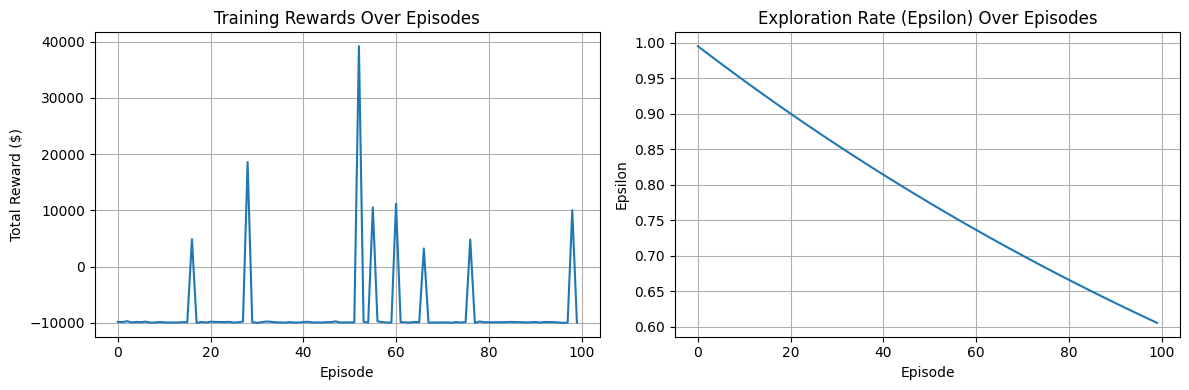


Training Statistics:
  Total episodes: 100
  Average reward: $-8,066.01
  Best reward: $39,172.55
  Worst reward: $-9,997.29
  Final epsilon: 0.606


In [23]:
# Train the agent
print("=" * 60)
print("Starting Training...")
print("=" * 60)

# Initialize environment and agent
env = TradingEnvironment(data)
agent = DQNAgent(state_size=4, action_size=3)

# Training hyperparameters
batch_size = 32
episodes = 100  # Start with 100 episodes for testing (increase to 500+ for better results)
total_rewards = []
epsilon_history = []

print(f"\nTraining Configuration:")
print(f"  Episodes: {episodes}")
print(f"  Batch size: {batch_size}")
print(f"  Initial epsilon: {agent.epsilon:.2f}")
print(f"  Learning rate: {agent.learning_rate}")
print(f"  Discount factor (gamma): {agent.gamma}")
print(f"\nStarting training...\n")

# Training loop
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    # Run one episode
    while not done:
        # Agent selects action
        action = agent.act(state, training=True)
        
        # Environment executes action
        next_state, reward, done, _ = env.step(action)
        
        # Agent stores experience
        agent.remember(state, action, reward, next_state, done)
        
        # Move to next state
        state = next_state
        total_reward += reward
        steps += 1
    
    # Train agent on batch of experiences
    agent.replay(batch_size)
    
    # Track metrics
    total_rewards.append(total_reward)
    epsilon_history.append(agent.epsilon)
    
    # Print progress
    if (episode + 1) % 10 == 0 or episode == 0:
        avg_reward = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else total_reward
        print(f"Episode {episode+1}/{episodes} | "
              f"Reward: ${total_reward:,.2f} | "
              f"Avg Reward (last 10): ${avg_reward:,.2f} | "
              f"Epsilon: {agent.epsilon:.3f} | "
              f"Steps: {steps}")

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(total_rewards)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward ($)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epsilon_history)
plt.title('Exploration Rate (Epsilon) Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final statistics
print(f"\nTraining Statistics:")
print(f"  Total episodes: {episodes}")
print(f"  Average reward: ${np.mean(total_rewards):,.2f}")
print(f"  Best reward: ${max(total_rewards):,.2f}")
print(f"  Worst reward: ${min(total_rewards):,.2f}")
print(f"  Final epsilon: {agent.epsilon:.3f}")


## Testing and Evaluation

After training, we test the agent on the same data (or new data) with exploration disabled (epsilon = 0). This shows how well the agent performs using only its learned knowledge.

### Evaluation Metrics

- **Final Balance**: Total cash at end of trading
- **Profit/Loss**: Final balance - Initial balance
- **Return Percentage**: (Profit / Initial balance) * 100
- **Number of Trades**: How many buy/sell actions were taken


Testing Trained Agent...
Testing with epsilon = 0 (no exploration)

Test Results:
Initial Balance: $10,000.00
Final Balance: $48.07
Total Profit/Loss: $-9,951.93
Return Percentage: -99.52%

Actions Taken:
  HOLD: 1328 times (89.3%)
  BUY: 159 times (10.7%)
  SELL: 0 times (0.0%)
Total Steps: 1487


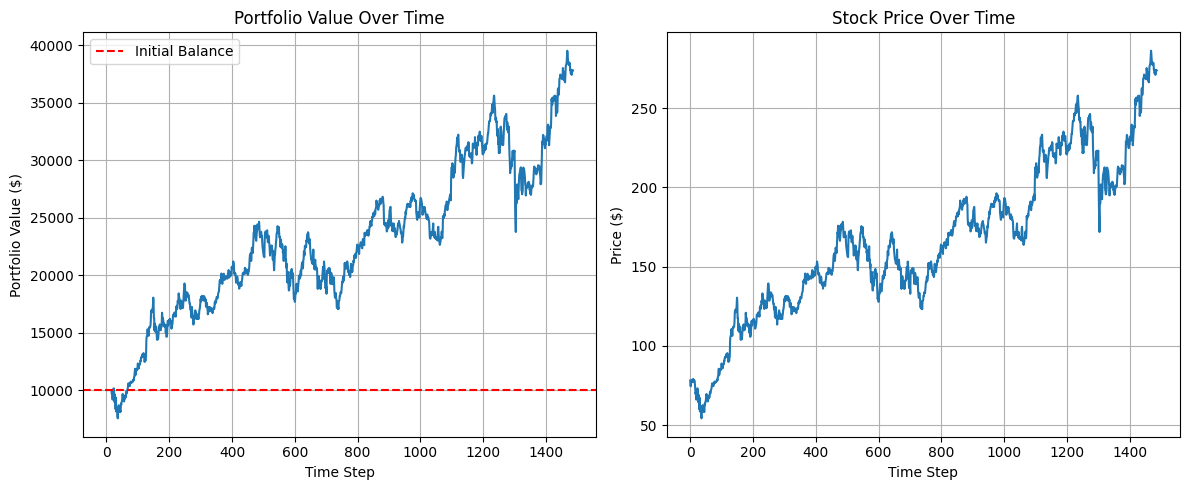


❌ Agent made a loss of $9,951.93 (-99.52% return)


In [24]:
# Test the trained agent
print("=" * 60)
print("Testing Trained Agent...")
print("=" * 60)

# Create a fresh environment for testing
test_env = TradingEnvironment(data, initial_balance=10000)
state = test_env.reset()
done = False

# Disable exploration (pure exploitation)
agent.epsilon = 0
print(f"Testing with epsilon = {agent.epsilon} (no exploration)")

# Track actions taken
actions_taken = {'HOLD': 0, 'BUY': 0, 'SELL': 0}
portfolio_values = [test_env.get_portfolio_value()]

# Simulate trading session
step = 0
while not done:
    # Agent selects best action (no exploration)
    action = agent.act(state, training=False)
    action_name = ACTIONS[action]
    actions_taken[action_name] += 1
    
    # Execute action
    next_state, reward, done, _ = test_env.step(action)
    
    # Track portfolio value
    if not done:
        portfolio_values.append(test_env.get_portfolio_value())
    
    state = next_state if next_state is not None else state
    step += 1

# Calculate results
final_balance = test_env.balance
initial_balance = test_env.initial_balance
profit = final_balance - initial_balance
return_pct = (profit / initial_balance) * 100

print(f"\n{'='*60}")
print("Test Results:")
print(f"{'='*60}")
print(f"Initial Balance: ${initial_balance:,.2f}")
print(f"Final Balance: ${final_balance:,.2f}")
print(f"Total Profit/Loss: ${profit:,.2f}")
print(f"Return Percentage: {return_pct:.2f}%")
print(f"\nActions Taken:")
for action, count in actions_taken.items():
    print(f"  {action}: {count} times ({count/step*100:.1f}%)")
print(f"Total Steps: {step}")

# Plot portfolio value over time
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(portfolio_values)
plt.axhline(y=initial_balance, color='r', linestyle='--', label='Initial Balance')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)

# Plot stock price for reference
plt.subplot(1, 2, 2)
plt.plot(data['Close'].values[:len(portfolio_values)])
plt.title('Stock Price Over Time')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Performance summary
if profit > 0:
    print(f"\n✅ Agent made a profit of ${profit:,.2f} ({return_pct:.2f}% return)")
else:
    print(f"\n❌ Agent made a loss of ${abs(profit):,.2f} ({return_pct:.2f}% return)")


## Advanced Techniques

### 1. State Normalization

Normalizing state features can improve training stability and convergence speed. Different features have different scales (price vs returns), which can cause issues.

### 2. Reward Shaping

Instead of only giving reward at the end, you can provide intermediate rewards based on portfolio value changes.

### 3. Target Network

Using a separate target network for Q-value estimation can stabilize training (Double DQN).

### 4. Prioritized Experience Replay

Sample important experiences more frequently instead of random sampling.

### 5. Additional Technical Indicators

Add more features like RSI, MACD, Bollinger Bands, etc.


In [25]:
# Example: Enhanced state extraction with normalization
def get_state_normalized(data, index, price_mean=None, price_std=None):
    """
    Extract normalized state representation.
    Normalization helps neural networks learn faster and more stable.
    """
    if price_mean is None:
        price_mean = data['Close'].mean()
    if price_std is None:
        price_std = data['Close'].std()
    
    state = np.array([
        (data.loc[index, 'Close'] - price_mean) / price_std,  # Normalized price
        (data.loc[index, 'SMA_5'] - price_mean) / price_std,  # Normalized SMA_5
        (data.loc[index, 'SMA_20'] - price_mean) / price_std,  # Normalized SMA_20
        data.loc[index, 'Returns']  # Returns are already normalized (percentage)
    ])
    return state

# Example: Enhanced reward function with intermediate rewards
class EnhancedTradingEnvironment(TradingEnvironment):
    """
    Enhanced environment with intermediate rewards based on portfolio value changes.
    """
    def __init__(self, data, initial_balance=10000):
        super().__init__(data, initial_balance)
        self.previous_portfolio_value = initial_balance
    
    def step(self, action):
        """Enhanced step with intermediate rewards."""
        price = float(self.data.loc[self.index, 'Close'])
        reward = 0
        
        # Execute action (same as before)
        if action == 1 and self.balance >= price:
            self.holdings = int(self.balance // price)
            self.balance -= self.holdings * price
        elif action == 2 and self.holdings > 0:
            self.balance += self.holdings * price
            self.holdings = 0
        
        self.index += 1
        done = self.index >= len(self.data) - 1
        
        # Calculate intermediate reward based on portfolio value change
        current_portfolio_value = self.get_portfolio_value()
        portfolio_change = current_portfolio_value - self.previous_portfolio_value
        reward = portfolio_change * 0.01  # Scale down intermediate rewards
        
        self.previous_portfolio_value = current_portfolio_value
        
        # Final reward at end
        if done:
            reward += self.balance - self.initial_balance
        
        next_state = get_state(self.data, self.index) if not done else None
        return next_state, reward, done, {}

print("✅ Advanced techniques examples created")
print("Note: These are examples. You can experiment with them in your own code.")


✅ Advanced techniques examples created
Note: These are examples. You can experiment with them in your own code.


## Edge Cases and Error Handling

### Common Edge Cases

1. **Empty or insufficient data**: Not enough data for training
2. **Invalid actions**: Trying to buy without money, sell without stocks
3. **Index out of bounds**: Accessing data beyond available range
4. **NaN values**: Missing data in technical indicators
5. **Division by zero**: When calculating returns or ratios
6. **Memory overflow**: Too many experiences in replay buffer
7. **Training instability**: Loss exploding or becoming NaN

### Error Handling Strategies

- Validate data before training
- Check action validity before execution
- Handle edge cases in environment step function
- Add bounds checking for array access
- Monitor training metrics for anomalies


In [26]:
# Robust Trading Environment with error handling
class RobustTradingEnvironment(TradingEnvironment):
    """
    Enhanced environment with comprehensive error handling.
    """
    
    def __init__(self, data, initial_balance=10000):
        # Validate data
        if data is None or len(data) == 0:
            raise ValueError("Data cannot be empty")
        if 'Close' not in data.columns:
            raise ValueError("Data must contain 'Close' column")
        
        super().__init__(data, initial_balance)
    
    def step(self, action):
        """Enhanced step with error handling."""
        # Validate action
        if action not in ACTIONS.keys():
            raise ValueError(f"Invalid action: {action}. Must be one of {list(ACTIONS.keys())}")
        
        # Check if we're at the end
        if self.index >= len(self.data):
            return None, 0, True, {'error': 'Index out of bounds'}
        
        try:
            price = float(self.data.loc[self.index, 'Close'])
            
            # Validate price
            if np.isnan(price) or price <= 0:
                raise ValueError(f"Invalid price at index {self.index}: {price}")
            
            reward = 0
            
            # Execute action with validation
            if action == 1:  # BUY
                if self.balance < price:
                    # Can't afford to buy - invalid action, but don't crash
                    pass  # Just hold
                else:
                    self.holdings = int(self.balance // price)
                    self.balance -= self.holdings * price
                    
            elif action == 2:  # SELL
                if self.holdings <= 0:
                    # Nothing to sell - invalid action, but don't crash
                    pass  # Just hold
                else:
                    self.balance += self.holdings * price
                    self.holdings = 0
            
            # Move to next time step
            self.index += 1
            done = self.index >= len(self.data) - 1
            
            # Calculate reward
            if done:
                reward = self.balance - self.initial_balance
            
            # Get next state
            if not done:
                next_state = get_state(self.data, self.index)
                # Validate state
                if np.any(np.isnan(next_state)):
                    raise ValueError(f"Invalid state at index {self.index}: contains NaN")
            else:
                next_state = None
            
            return next_state, reward, done, {}
            
        except Exception as e:
            print(f"⚠️ Error in step function: {e}")
            return None, 0, True, {'error': str(e)}

# Robust agent with error handling
class RobustDQNAgent(DQNAgent):
    """
    Enhanced agent with error handling and validation.
    """
    
    def replay(self, batch_size):
        """Enhanced replay with error handling."""
        if len(self.memory) < batch_size:
            return
        
        try:
            minibatch = random.sample(self.memory, batch_size)
            
            for state, action, reward, next_state, done in minibatch:
                # Validate inputs
                if np.any(np.isnan(state)):
                    continue  # Skip invalid states
                
                target = reward
                
                if not done and next_state is not None:
                    if np.any(np.isnan(next_state)):
                        continue  # Skip invalid next states
                    
                    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
                    target += self.gamma * torch.max(self.model(next_state_tensor)).item()
                
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                target_tensor = self.model(state_tensor).clone().detach()
                target_tensor[0][action] = target
                
                self.optimizer.zero_grad()
                output = self.model(state_tensor)
                loss = self.criterion(output, target_tensor)
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print("⚠️ NaN loss detected, skipping this batch")
                    continue
                
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
        except Exception as e:
            print(f"⚠️ Error in replay: {e}")

print("✅ Robust versions with error handling created")


✅ Robust versions with error handling created


In [27]:
# Diagnostic function to check training health
def diagnose_training_health(agent, recent_rewards, recent_losses=None):
    """
    Diagnose potential issues with training.
    
    Parameters:
    -----------
    agent : DQNAgent
        The training agent
    recent_rewards : list
        Recent episode rewards
    recent_losses : list, optional
        Recent training losses
    """
    print("=" * 60)
    print("Training Health Diagnostics")
    print("=" * 60)
    
    # Check epsilon
    print(f"\n1. Exploration Rate (Epsilon):")
    print(f"   Current: {agent.epsilon:.4f}")
    print(f"   Minimum: {agent.epsilon_min:.4f}")
    if agent.epsilon <= agent.epsilon_min:
        print("   ⚠️  Epsilon at minimum - agent is mostly exploiting")
    else:
        print("   ✅ Epsilon above minimum - still exploring")
    
    # Check memory
    print(f"\n2. Experience Replay Memory:")
    print(f"   Current size: {len(agent.memory)}/{agent.memory.maxlen}")
    if len(agent.memory) < 100:
        print("   ⚠️  Memory is small - may need more experiences")
    else:
        print("   ✅ Memory has sufficient experiences")
    
    # Check rewards
    if len(recent_rewards) > 0:
        print(f"\n3. Reward Statistics (last {len(recent_rewards)} episodes):")
        print(f"   Mean: ${np.mean(recent_rewards):,.2f}")
        print(f"   Std: ${np.std(recent_rewards):,.2f}")
        print(f"   Min: ${min(recent_rewards):,.2f}")
        print(f"   Max: ${max(recent_rewards):,.2f}")
        
        # Check if improving
        if len(recent_rewards) >= 20:
            first_half = np.mean(recent_rewards[:len(recent_rewards)//2])
            second_half = np.mean(recent_rewards[len(recent_rewards)//2:])
            improvement = second_half - first_half
            print(f"   Trend: ${improvement:,.2f} change (positive = improving)")
            if improvement < 0:
                print("   ⚠️  Rewards not improving - may need hyperparameter tuning")
            else:
                print("   ✅ Rewards are improving")
    
    # Check losses
    if recent_losses and len(recent_losses) > 0:
        print(f"\n4. Loss Statistics (last {len(recent_losses)} batches):")
        print(f"   Mean: {np.mean(recent_losses):.6f}")
        print(f"   Min: {min(recent_losses):.6f}")
        print(f"   Max: {max(recent_losses):.6f}")
        
        if np.any(np.isnan(recent_losses)):
            print("   ❌ NaN losses detected - check data and learning rate")
        else:
            print("   ✅ No NaN losses")
    
    # Check model parameters
    print(f"\n5. Model Parameters:")
    total_params = sum(p.numel() for p in agent.model.parameters())
    trainable_params = sum(p.numel() for p in agent.model.parameters() if p.requires_grad)
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    # Check for NaN in model
    has_nan = False
    for name, param in agent.model.named_parameters():
        if torch.isnan(param).any():
            print(f"   ❌ NaN detected in {name}")
            has_nan = True
    if not has_nan:
        print("   ✅ No NaN in model parameters")
    
    print("\n" + "=" * 60)

# Example usage (uncomment to test)
# diagnose_training_health(agent, total_rewards[-20:] if len(total_rewards) >= 20 else total_rewards)


## Exercises

Practice exercises to reinforce your understanding and experiment with the concepts.

### Exercise 1: Modify Action Space

**Task**: Add a new action "PARTIAL_SELL" that sells half of the holdings instead of all.

**Steps**:
1. Update the `ACTIONS` dictionary
2. Modify the `TradingEnvironment.step()` method
3. Update the agent's `action_size`
4. Test the changes

**Expected Outcome**: Agent can now partially sell stocks.

---

### Exercise 2: Add More Technical Indicators

**Task**: Add RSI (Relative Strength Index) to the state representation.

**Steps**:
1. Calculate RSI using pandas
2. Add RSI to the state extraction function
3. Update `state_size` in agent initialization
4. Retrain and compare results

**Hint**: RSI formula: `RSI = 100 - (100 / (1 + RS))` where `RS = average gain / average loss`

---

### Exercise 3: Implement Reward Shaping

**Task**: Modify the environment to give intermediate rewards based on portfolio value changes.

**Steps**:
1. Track previous portfolio value
2. Calculate change in portfolio value each step
3. Add small reward proportional to positive changes
4. Compare training results with original reward function

---

### Exercise 4: Hyperparameter Tuning

**Task**: Experiment with different hyperparameter values and find the best combination.

**Parameters to tune**:
- `learning_rate`: Try [0.0001, 0.001, 0.01]
- `gamma`: Try [0.9, 0.95, 0.99]
- `epsilon_decay`: Try [0.99, 0.995, 0.999]
- `batch_size`: Try [16, 32, 64]

**Steps**:
1. Create a function to train with different hyperparameters
2. Track performance for each combination
3. Find the best performing set
4. Visualize results

---

### Exercise 5: Test on Different Stocks

**Task**: Train the agent on one stock and test on another.

**Steps**:
1. Download data for two different stocks (e.g., AAPL and MSFT)
2. Train on stock A
3. Test on stock B
4. Compare performance
5. Discuss transfer learning implications

---

### Exercise 6: Implement Model Saving/Loading

**Task**: Add functionality to save and load trained models.

**Steps**:
1. Save model after training
2. Load model for testing
3. Add checkpoint saving during training
4. Implement best model saving (save when performance improves)

---

### Exercise 7: Add Visualization

**Task**: Create visualizations showing:
- Agent's actions over time
- Portfolio value vs stock price
- Buy/sell signals on price chart

**Steps**:
1. Track all actions during testing
2. Plot price chart with buy/sell markers
3. Plot portfolio value alongside price
4. Add annotations for key events

---

### Exercise 8: Compare Different Network Architectures

**Task**: Test different neural network architectures and compare performance.

**Architectures to try**:
- Deeper network (3-4 hidden layers)
- Wider network (128 or 256 neurons per layer)
- Different activation functions (tanh, LeakyReLU)

**Steps**:
1. Create multiple DQN architectures
2. Train each with same hyperparameters
3. Compare final performance
4. Analyze training curves

---

### Exercise 9: Implement Double DQN

**Task**: Implement Double DQN to improve training stability.

**Key Changes**:
- Create a target network (copy of main network)
- Update target network periodically
- Use target network for Q-value estimation in Bellman equation

**Steps**:
1. Add target network to DQNAgent
2. Implement periodic target network updates
3. Modify replay function to use target network
4. Compare with basic DQN

---

### Exercise 10: Create a Trading Strategy Evaluator

**Task**: Build a function that evaluates different trading strategies and compares them.

**Strategies to compare**:
- Random trading
- Buy and hold
- Your trained DQN agent
- Simple rule-based strategy (e.g., buy when SMA_5 > SMA_20)

**Steps**:
1. Implement each strategy
2. Run on same data
3. Compare returns, Sharpe ratio, max drawdown
4. Create comparison visualization


### Exercise Solutions (Try First, Then Check!)

<details>
<summary>Click to view Exercise 1 Solution: Modify Action Space</summary>

```python
# Updated action space
ACTIONS = {0: "HOLD", 1: "BUY", 2: "SELL", 3: "PARTIAL_SELL"}

# Modified step function
def step(self, action):
    price = float(self.data.loc[self.index, 'Close'])
    reward = 0
    
    if action == 1 and self.balance >= price:  # BUY
        self.holdings = int(self.balance // price)
        self.balance -= self.holdings * price
    elif action == 2 and self.holdings > 0:  # SELL
        self.balance += self.holdings * price
        self.holdings = 0
    elif action == 3 and self.holdings > 0:  # PARTIAL_SELL
        sell_amount = self.holdings // 2
        self.balance += sell_amount * price
        self.holdings -= sell_amount
    
    self.index += 1
    done = self.index >= len(self.data) - 1
    
    if done:
        reward = self.balance - self.initial_balance
    
    next_state = get_state(self.data, self.index) if not done else None
    return next_state, reward, done, {}

# Update agent
agent = DQNAgent(state_size=4, action_size=4)  # Changed from 3 to 4
```

</details>

<details>
<summary>Click to view Exercise 6 Solution: Model Saving/Loading</summary>

```python
# Save model
def save_model(agent, filepath):
    """Save agent model and hyperparameters."""
    save_dict = {
        'model_state_dict': agent.model.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': agent.epsilon,
        'state_size': agent.state_size,
        'action_size': agent.action_size,
        'gamma': agent.gamma,
        'learning_rate': agent.learning_rate
    }
    torch.save(save_dict, filepath)
    print(f"✅ Model saved to {filepath}")

# Load model
def load_model(filepath, agent=None):
    """Load agent model and hyperparameters."""
    checkpoint = torch.load(filepath)
    
    if agent is None:
        agent = DQNAgent(
            state_size=checkpoint['state_size'],
            action_size=checkpoint['action_size'],
            gamma=checkpoint['gamma'],
            learning_rate=checkpoint['learning_rate']
        )
    
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    agent.epsilon = checkpoint['epsilon']
    agent.model.eval()
    
    print(f"✅ Model loaded from {filepath}")
    return agent

# Usage
# save_model(agent, 'trading_agent.pth')
# loaded_agent = load_model('trading_agent.pth')
```

</details>


## Summary

### What We've Learned

1. **Agentic AI Fundamentals**: Understanding how agents perceive, decide, and act
2. **Reinforcement Learning**: Learning optimal policies through trial and error
3. **Deep Q-Learning**: Combining neural networks with Q-learning for complex problems
4. **Trading Environment**: Building a simulation environment for stock trading
5. **Experience Replay**: Storing and learning from past experiences
6. **Exploration vs Exploitation**: Balancing learning new strategies vs using known ones
7. **Hyperparameter Tuning**: Understanding how parameters affect learning
8. **Error Handling**: Building robust systems that handle edge cases

### Key Takeaways

- **Agentic AI** enables autonomous decision-making through reinforcement learning
- **DQN** is powerful for problems with large state spaces
- **Experience replay** improves learning efficiency
- **Hyperparameters** significantly affect training performance
- **Reward design** is crucial for agent behavior
- **Testing and evaluation** are essential for validating agent performance

### Next Steps

1. **Experiment**: Try different hyperparameters, architectures, and strategies
2. **Extend**: Add more features, indicators, and actions
3. **Improve**: Implement advanced techniques (Double DQN, Prioritized Replay, etc.)
4. **Deploy**: Create a real-time trading system (with caution!)
5. **Learn More**: Explore other RL algorithms (PPO, A3C, etc.)

### Important Notes

⚠️ **Disclaimer**: This is an educational project. Real trading involves:
- Transaction costs and fees
- Market impact of trades
- Slippage
- Risk management
- Regulatory considerations
- Real-time data and execution

**Never trade real money without proper testing, risk management, and understanding of the markets!**

### Resources

- [Deep Q-Learning Paper (Mnih et al., 2015)](https://arxiv.org/abs/1312.5602)
- [PyTorch Documentation](https://pytorch.org/docs/)
- [Reinforcement Learning: An Introduction (Sutton & Barto)](http://incompleteideas.net/book/)
- [OpenAI Gym](https://gym.openai.com/) - For more RL environments

---

## Conclusion

Congratulations! You've learned how to build an AI trading agent using Agentic AI and Deep Q-Learning. You now understand:

- How to implement Deep Q-Networks
- How to create reinforcement learning environments
- How to train agents to make autonomous decisions
- How to handle edge cases and troubleshoot issues
- How to evaluate and improve agent performance

Keep experimenting and learning! The field of reinforcement learning is rapidly evolving, and there's always more to discover.

**Happy Learning! 🚀**
